## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

from sherlock_helpers.constants import DATA_DIR, FIG_DIR
from sherlock_helpers.functions import (
    corr_mean,
    get_recall_text, 
    get_video_text, 
    show_source
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Inspect some functions

In [2]:
show_source(corr_mean)

In [3]:
show_source(get_video_text)

In [4]:
show_source(get_recall_text)

## Set plotting params

In [5]:
sns.set_context('paper')
sns.set_style('ticks')
sns.set_palette('hls', 17)
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [6]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'), allow_pickle=True)
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)

video_event_times = np.load(DATA_DIR.joinpath('video_event_times.npy'), allow_pickle=True)
recall_event_times = np.load(DATA_DIR.joinpath('recall_event_times.npy'), allow_pickle=True)

matches = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)

## Compute distinctiveness

In [7]:
dist_df = pd.DataFrame(index=range(len(recall_events)), 
                       columns=range(video_events.shape[0]))

for sub, rec in enumerate(recall_events):
    sub_matches = matches[sub]
    sub_cm = np.corrcoef(rec)
    sub_precs = np.diag(1 - cdist(video_events[sub_matches], rec, 'correlation'))
    for i, vid_event in enumerate(np.unique(sub_matches)):
        matched_ix = np.where(sub_matches == vid_event)[0]
        best_match = matched_ix[sub_precs[matched_ix].argmax()]
        d = 1 - corr_mean(sub_cm[best_match][sub_matches != vid_event])
        dist_df.loc[sub, vid_event] = d
        
ranked_order = dist_df.mean(axis=0).argsort()[::-1] + 1
dist_df['Participant'] = [f'P{i + 1}' for i in range(len(recall_events))]
dist_df = dist_df.melt(id_vars=['Participant'], 
                       var_name='Video event', 
                       value_name='Distinctiveness')
dist_df['Distinctiveness'] = dist_df['Distinctiveness'].astype(np.float64)
dist_df['Video event'] += 1

## Plot by video event

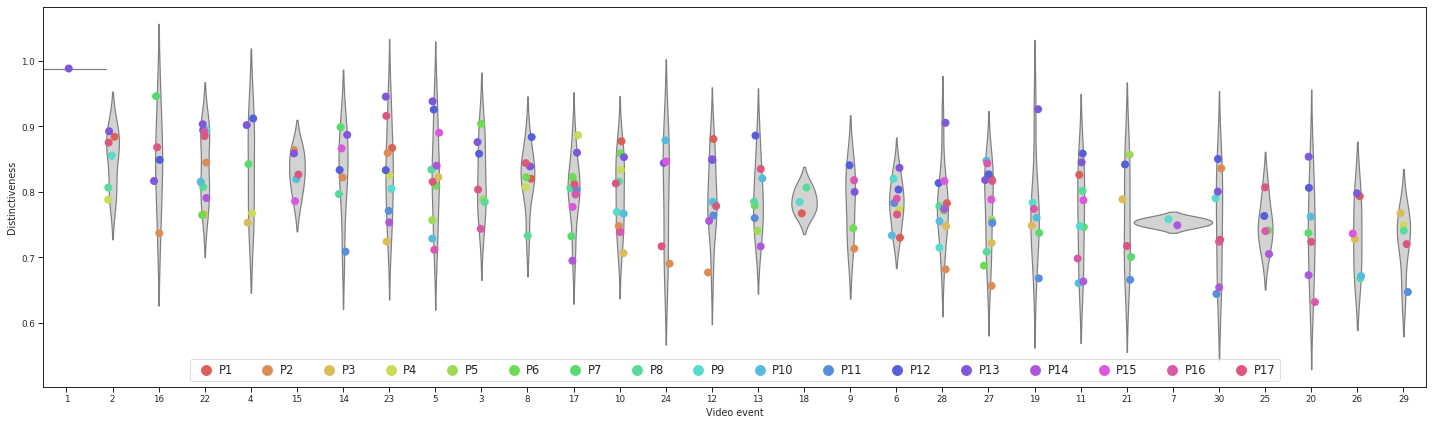

In [8]:
g = sns.catplot(x='Video event', 
                y='Distinctiveness', 
                data=dist_df, 
                kind='violin',
                order=ranked_order, 
                width=1.7, 
                color='lightgrey', 
                inner=None)

g.fig.set_size_inches(20, 6)
sns.stripplot(x='Video event', 
              y='Distinctiveness', 
              hue='Participant', 
              data=dist_df, 
              order=ranked_order, 
              size=8, 
              ax=g.ax)

hs, ls = g.ax.get_legend_handles_labels()
g.ax.legend_.remove()
g.ax.legend(hs, 
            ls, 
            loc='lower center', 
            ncol=17, 
            handletextpad=.1, 
            fontsize='large', 
            markerscale=1.3)

for sp in g.ax.spines.values():
    sp.set_visible(True)

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('tmp', 'distinctiveness_detail_vid_all.pdf'))
plt.show()

## Recover text from the video and most and least distinctive recall for a sample event

In [9]:
dist_ranges = dist_df.groupby('Video event')['Distinctiveness'].agg(lambda x: x.max() - x.min())
sample_event = dist_ranges.idxmax()
event_dist_scores = dist_df.loc[dist_df['Video event'] == sample_event]
high_rec = event_dist_scores.loc[event_dist_scores['Distinctiveness'].idxmax(), 'Participant']
low_rec = event_dist_scores.loc[event_dist_scores['Distinctiveness'].idxmin(), 'Participant']

print(f'video event: {sample_event}\n', 
      f'most distinctive: {high_rec}\n', 
      f'least distinctive: {low_rec}')

video event: 19
 most distinctive: P13
 least distinctive: P11


In [10]:
high_sub, low_sub = int(high_rec[1:]) - 1, int(low_rec[1:]) - 1

sample_event_bounds = video_event_times[sample_event - 1]
prev_event_bounds = video_event_times[sample_event - 2]
prev2_event_bounds = video_event_times[sample_event - 6]
next_event_bounds =  video_event_times[sample_event]
next2_event_bounds =  video_event_times[sample_event + 1]

video_event_text = get_video_text(*sample_event_bounds)
prev_event_text = get_video_text(*prev_event_bounds)
prev2_event_text = get_video_text(*prev2_event_bounds)
next_event_text = get_video_text(*next_event_bounds)
next2_event_text = get_video_text(*next2_event_bounds)

In [11]:
high_rec_bounds = np.array(recall_event_times[high_sub])[matches[high_sub] == sample_event - 1][0]
low_rec_bounds = np.array(recall_event_times[low_sub])[matches[low_sub] == sample_event - 1][0]

high_rec_text = get_recall_text(*high_rec_bounds, subid=high_sub + 1)
low_rec_text = get_recall_text(*low_rec_bounds, subid=low_sub + 1)

In [12]:
print(video_event_text)

John looks at Sherlock in shock as Sherlock gets up and continues: "…so what or rather whom does she remove her rings for?" Sherlock: "Clearly not one lover; she'd never sustain the fiction of being single over that amount of time, so more likely a string of them. Simple." John admiringly says to Sherlock: "That's brilliant." Sherlock looks round at him and John immediately says: "Sorry."  Lestrade asks: "Cardiff?" Sherlock says: "It's obvious, isn't it?" John: "It's not obvious to me." and stares at Sherlock.  Sherlock pauses as he looks at the other two men and says seriously: "Dear God, what is it like in your funny little brains? It must be so boring." Sherlock turns back to the body and explains in a lively manner: "Her coat: it's slightly damp. She's been in heavy rain in the last few hours. No rain anywhere in London in that time." Sherlock continues, looking at Lestrade: "Under her coat collar is damp, too. She's turned it up against the wind. She's got an umbrella in her left-

In [13]:
print(prev_event_text)

John looks up from the body to Sherlock and says: "Hm?" Then he turns his head towards Lestrade, silently seeking his permission.  Lestrade, a little tetchily, says: "Oh, do as he says. Help yourself" He turns and opens the door, going outside.  Lestrade says in the background: "Anderson, keep everyone out for a couple of minutes" as John and Sherlock approach the corpse on each of her sides and squat down. John painfully lowers himself to one knee on the other side, learning heavily on his cane to support himself.  Sherlock looks toward John and asks: "Well?" John asks softly: "What am I doing here?" Sherlock whispers: "Helping me make a point." John softly replies: "I'm supposed to be helping you pay the rent." Sherlock replies softly: "Yeah well, this is more fun." John asks: "Fun? There's a woman lying dead." Sherlock admits: "Perfectly sound analysis, but I was hoping you'd go deeper." Lestrade comes back into the room and stands just inside the doorway John drags his other leg do

In [14]:
print(prev2_event_text)

Sherlock (looking impressed with himself): "Spot on, then. I didn't expect to be right about everything." John: "Harry's short for Harriet." Sherlock stops dead in his tracks and says: "Harry's your sister." John continues walking until he realises Sherlock has stopped. John, continusing onwards, asks: "Look, what exactly am I supposed to be doing here?" Sherlock, furiously and with gritted teeth, says: "Sister!" and catches up with John.  John: "No, seriously, what am I doing here?" Sherlock, exasperated, adds: "There's always something." The two men continue walking.  Sherlock and John approach the police tape where they are met by Sergeant Donovan. Donovan says to Sherlock: "Hello, freak." Sherlock: "I'm here to see Detective Inspector Lestrade." Donovan asks: "Why?" Sherlock answers: "I was invited." Donovan asks again: "Why?" Sherlock says sarcastically: "I think he wants me to take a look." Donovan: "Well, you know what I think, don't you?" Sherlock says: "Always, Sally" as he li

In [15]:
print(next_event_text)

Sherlock, slowing down, but still making his way down the stairs, says: "But they take the poison themselves; they chew, swallow the pills themselves. There are clear signs. Even you lot couldn't miss them" Lestrade: "Right, yeah, thanks!" He callls out loudly down the stairs: "AND…?" John stays silent beside Lestrade. The two stay upstairs.  Sherlock reaches a floor where Anderson and two other people dressed in coveralls as well as another policeman are patiently waiting. Sherlock calls up the stairs to answer Lestrade: "It's murder, all of them. I don't know how, but they're not suicides, they're killings..." View of Lestrade and John looking down at the stair railings. Sherlock continues: "…serial killings." Sherlock abruptly holds his hands in front of his face in delight. Sherlock says joyfully: "We've got ourselves a serial killer. I love those. There's always something to look forward to." Sherlock continues down the next flight of stairs quickly. He passes by another policeman

In [16]:
print(next2_event_text)

John walks toward the police tape, still looking around. Donovan is at the police tape speaking with a police man.  Donovan, standing at the tape alongside a police man, sees him and says: "He's gone." John asks Donovan: "Sherlock Holmes?" Donovan: "Yeah, he just took off. He does that." John asks Donovan: "Is he coming back?" Donovan: "Didn't look like it." John: "Right." He looks around the area again thoughtfully, unsure of what to do. John says quietly: "Right….yes." Donovan has gone back to talking with the police man near the tape.  John turns to Donovan again and asks: "Sorry, where am I?" Donovan turns around and answers: "Brixton."  John asks Donovan: "Right. Er, d'you know where I could get a cab? It's just, er… well…" H e looks down awkwardly at his walking stick and says: "…my leg." Donovan: "Er…" She stepss over to the tape and lifts it for him and says: "…try the main road." John says: "Thanks" and ducks under the tape.  Donovan says: "But you're not his friend." John sto

In [17]:
print(high_rec_text)

And Sherlock is like its the same poison as before, its the poison from the serial suicides. And then there's a conversation about the facts that Sherlock has discovered. Okay late 30s, serial adulterer, had a lot of lovers, unhappily married for the last 10 years, you can see that her wedding ring is dirty, all her other jewelry is clean, but the inside is more clean than the outside which means that only polishing??? regularly. She needed to have a bunch of string of lovers because its hard to pretend to be single for a long time, a number of boyfriends, knew that she was married. She probably worked, she was a businesswoman judging by the attire, media probably judging by the suit color. She was in the rain because her jacket was wet, it was also really windy, because well so this is the response, her outfit is a response to the Sergeant's surprise when the guy says she was from this specific town and she only wanted to stay overnight. He's like how do you know this? Well the coat i

In [18]:
print(low_rec_text)

He also notices that her jewelry is new, her coat is wet. And so he diagnoses that she is from out of town because her coat is still wet. And she has an umbrella but she didn't use it which means that it was windy. So its about like a two hour, two hours out of town or something. And so he figures out where she is from. So he tells all this to inspector. And the inspector kind of just, he's excited that Sherlock has figured this out. And then Sherlock says that this person has made a mistake, like the murderer has made a mistake. And when Watson asks him why, he says its because she's in pink. And he means that she had a suitcase, because he notices that on the back of her stockings there were splash marks indicating that she was pulling along a suitcase. And Watson helped by saying that she died through asphyxiation, possibly choking on her own vomit. So that way he came into--he was handy. And then so Sherlock runs out and Watson comes behind and asks the inspector where Sherlock wen